**Chapter 14 – Deep Computer Vision Using Convolutional Neural Networks**

_This notebook contains the sample from https://github.com/ageron/handson-ml2/ and https://github.com/fchollet/deep-learning-with-python-notebooks_

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math604/blob/master/static_files/presentations/03_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math604/blob/master/static_files/presentations/03_Convolutional_Neural_Networks.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale and RGB images:

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# What is a Convolution?

A neuron’s weights can be represented as a small image the size of the receptive field. For example, below shows two possible sets of weights, called filters (or convolution kernels). In TensorFlow, each input image is typically represented as a 3D tensor of shape `[height, width, channels]`. A mini-batch is represented as a 4D tensor of shape `[mini-batch size, height, width, channels]`. The weights of a convolutional layer are represented as a 4D tensor of shape `[fh, fw, fn', fn]`. The bias terms of a convolutional layer are simply represented as a 1D tensor of shape `[fn]`.

Let’s look at a simple example. The following code loads two sample images, using Scikit-Learn’s `load_sample_images()` (which loads two color images, one of a Chinese temple, and the other of a flower). The pixel intensities (for each color channel) is represented as a byte from 0 to 255, so we scale these features simply by dividing by 255, to get floats ranging from 0 to 1. Then we create two `7 × 7` filters (one with a vertical white line in the middle, and the other with a horizontal white line in the middle).

In [ ]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32) # [height, width, channel of inputs, channel of feature maps]
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line
images.shape

(2, 427, 640, 3)

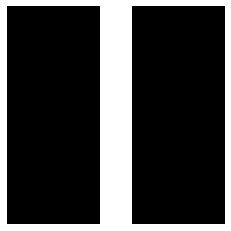

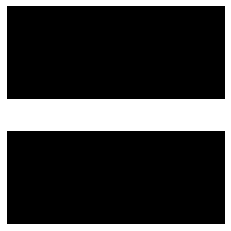

In [ ]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

Now if all neurons in a layer use the same vertical line filter (and the same bias term), and you feed the network with the image, the
layer will output a feature maps. Here, we apply them to both images using the `tf.nn.conv2d()` function, which is part of TensorFlow’s low-level Deep Learning API. In this example, we use zero padding (`padding="SAME"`) and a stride of 2

Notice that the vertical white lines get enhanced in one feature map while the rest gets blurred. Similarly, the other feature map is what you get if all neurons use the same horizontal line filter; notice that the horizontal white lines get enhanced while the rest is blurred out. Thus, a layer full of neurons using the same filter outputs a feature map, which highlights the areas in an image that activate the filter the most. Of course you do not have to define the filters manually: instead, during training the convolutional layer will **automatically learn the most useful filters** for its task, and the layers above will learn to combine them into more complex patterns.

In [ ]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
outputs.shape # [batches, height, width, channel of feature maps]

TensorShape([2, 427, 640, 2])

The output is a 4D tensor. The dimensions are: batch size, height, width, channels. The first dimension (batch size) is 2 since there are 2 input images. The next two dimensions are the height and width of the output feature maps: since `padding="SAME"` and `strides=1`, the output feature maps have the same height and width as the input images (in this case, 427×640). Lastly, this convolutional layer has 2 filters, so the last dimension is 2: there are 2 output feature maps per input image.

Saving figure china_original


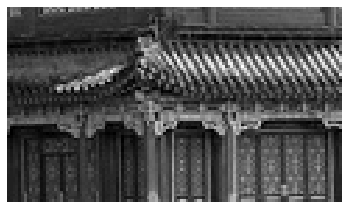

Saving figure china_vertical


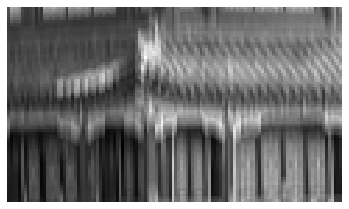

Saving figure china_horizontal


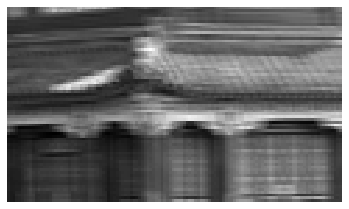

In [ ]:
def crop(images):
    return images[150:220, 130:250] #crop for better visulization

plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

## Convolutional Layer

Instead of manually creating the variables, however, you can simply use the `keras.layers.Conv2D` layer. The code below creates a Conv2D layer with 32 filters, each `3 × 3`, using a stride of 1 (both horizontally and vertically), SAME padding, and applying the ReLU activation function to its outputs. As you can see, convolutional layers have quite a few hyperparameters: you must choose the number of filters, their height and width, the strides, and the padding type. As always, you can use cross-validation to find the right hyperparameter
values, but this is very time-consuming. We will discuss common CNN architectures later, to give you some idea of what hyperparameter values work best in practice.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1, 
                           padding="SAME", activation="relu", input_shape=outputs.shape)

Let's call this layer, passing it the two test images:

In [ ]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

Since the filters are initialized randomly, they'll initially detect random patterns. Let's take a look at the 2 output features maps for each image:

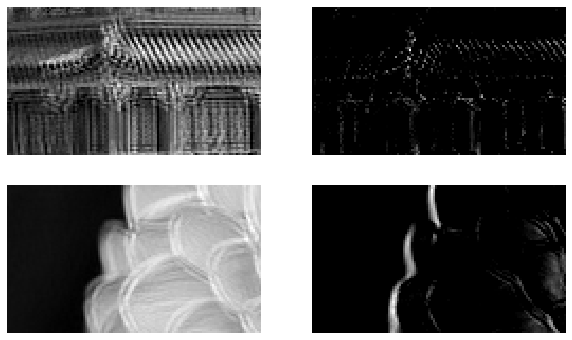

In [ ]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

Although the filters were initialized randomly, the second filter happens to act like an edge detector. Randomly initialized filters often act this way, which is quite fortunate since detecting edges is quite useful in image processing. If we want, we can set the filters to be the ones we manually defined earlier, and set the biases to zeros (in real life we will almost never need to set filters or biases manually, as the convolutional layer will just learn the appropriate filters and biases during training):

In [ ]:
len(conv.get_weights()), conv.get_weights()[0].shape, conv.get_weights()[1].shape

(2, (7, 7, 3, 2), (2,))

In [ ]:
conv.set_weights([filters, np.zeros(2)]) # bias term

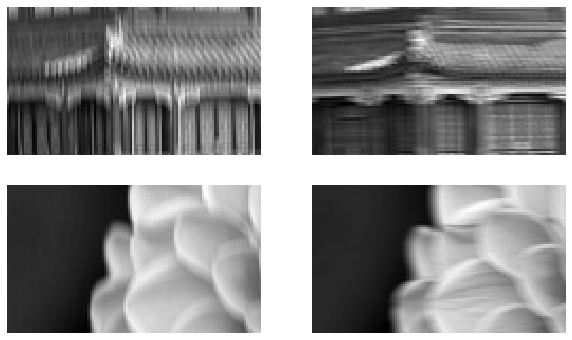

In [ ]:
# Now let's call this layer again on the same two images, and let's check that the 
# output feature maps do highlight vertical lines and horizontal lines, respectively (as earlier):
conv_outputs = conv(images)
conv_outputs.shape 
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

## VALID vs SAME padding

In [ ]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Using `"SAME"` padding is equivalent to padding manually using `manual_same_padding()` then using `"VALID"` padding (confusingly, `"VALID"` padding means no padding at all):

In [ ]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))
# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

You can find other useful kernels here https://setosa.io/ev/image-kernels/

# Pooling layer

## Max pooling

Implementing a max pooling layer in TensorFlow is quite easy. The following code
creates a max pooling layer using a 2 × 2 kernel. **The strides default to the kernel size**, so this layer will use a stride of 2 (both horizontally and vertically). By default, it uses VALID padding (i.e., no padding at all):

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [ ]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


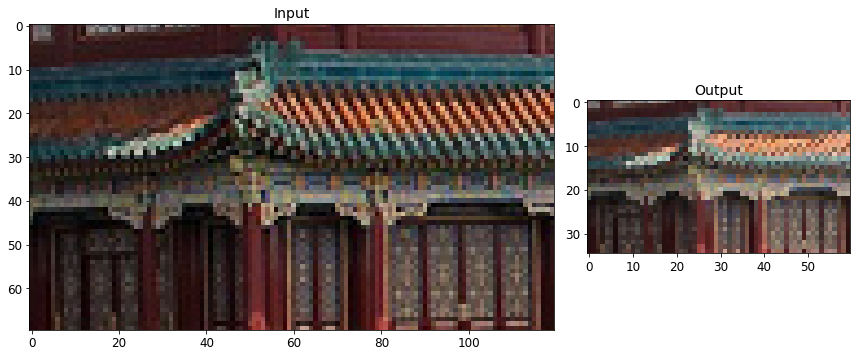

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
save_fig("china_max_pooling")
plt.show()

## Average pooling

To create an average pooling layer, just use `AvgPool2D` instead of MaxPool2D. As you might expect, it works exactly like a max pooling layer, except it computes the mean rather than the max.

In [ ]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [ ]:
output_avg = avg_pool(cropped_images)

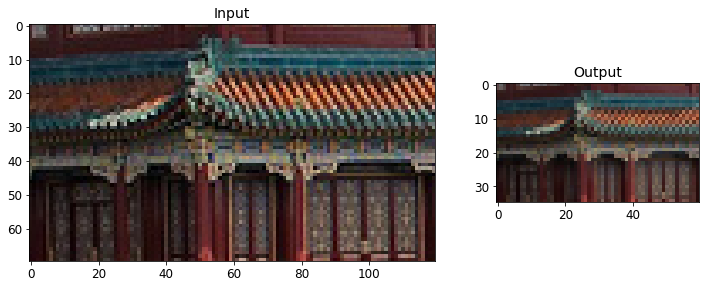

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
plt.show()

## Global Average Pooling

One last type of pooling layer that you will often see in modern architectures is the global average pooling layer. It works very differently: all it does is compute the mean of each entire feature map (it’s like an average pooling layer using a pooling kernel with the same spatial dimensions as the inputs). **This means that it just outputs a single number per feature map and per instance.** Although this is of course extremely destructive (most of the information in the feature map is lost), it can be useful as the output layer. To create such a layer, simply use the `keras.layers.GlobalAvgPool2D` class:

In [ ]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

In [ ]:
# It is the same as using low level API to perform reduction
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

Now you know all the building blocks to create a convolutional neural network. Let’s see how to assemble them.

# Tackling Fashion MNIST With a CNN

Before delving into the code, you can go through https://poloclub.github.io/cnn-explainer/ to make sure you understand every piece of CNN.

Typical CNN architectures stack a few convolutional layers (each one generally followed by a ReLU layer), then a pooling layer, then another few convolutional layers (+ReLU), then another pooling layer, and so on. The image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper (i.e.,with more feature maps) thanks to the convolutional layers. At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers (+ReLUs), and the final layer outputs the prediction (e.g., a softmax layer that outputs estimated class probabilities).

<p align="center">
<img src="https://drive.google.com/uc?id=1_V3lt-SoutJBKSGXoX7X8laWlgDk_NsG" alt="drawing" width="600"/>
</p>

Here is how you can implement a simple CNN to tackle the fashion MNIST dataset

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7 # To avoid infinity after transformation
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_train.shape, X_valid.shape, X_test.shape

4431872/4422102 [==============================] - 0s 0us/step


((55000, 28, 28, 1), (5000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=32, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 3, 3, 128)       

In this code, we start by using the `partial()` function to define a thin wrapper around the `Conv2D` class, called `DefaultConv2D`: it simply avoids having to repeat the same hyperparameter values over and over again.

* The first layer sets `input_shape=[28, 28, 1]`, which means the images are 28 × 28 pixels, with a single color channel (i.e., grayscale).
* Next, we have a max pooling layer, which divides each spatial dimension by a factor of two (since `pool_size=2`).
* Then we repeat the same structure twice: convolutional layers followed by a max pooling layer. For larger images, we could repeat this structure several times (the number of repetitions is a hyperparameter you can tune).
* Note that the number of filters grows as we climb up the CNN towards the output layer (it is initially 32, then 64, then 128): it makes sense for it to grow in the image setting, since the number of low level features is often fairly low (e.g., small circles, horizontal lines, etc.), but there are many different ways to combine them into higher level features. **It is a common practice to double the number of filters after each pooling layer: since a pooling layer divides each spatial dimension by a factor of 2**, we can afford doubling the number of feature maps in the next layer, without fear of exploding the number of parameters, memory usage, or computational load.
* Next is the fully connected network, composed of 1 hidden dense layers and a dense output layer. **Note that we must flatten its inputs, since a dense network expects a 1D array of features for each instance**. We also add two dropout layers, with a dropout rate of 50% each, to reduce overfitting.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 19s 10ms/step - loss: 0.6003 - accuracy: 0.7875 - val_loss: 0.3394 - val_accuracy: 0.8748
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3836 - accuracy: 0.8668 - val_loss: 0.2886 - val_accuracy: 0.8900
Epoch 3/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3224 - accuracy: 0.8872 - val_loss: 0.2704 - val_accuracy: 0.9006
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2874 - accuracy: 0.8984 - val_loss: 0.2468 - val_accuracy: 0.9094
Epoch 5/10
1719/1719 [==============================] - 16s 10ms/step - loss: 0.2592 - accuracy: 0.9084 - val_loss: 0.2448 - val_accuracy: 0.9110
Epoch 6/10
1719/1719 [==============================] - 16s 10ms/step - loss: 0.2363 - accuracy: 0.9159 - val_loss: 0.2439 - val_accuracy: 0.9132
Epoch 7/10
1719/1719 [==============================] - 16s 10ms/step - loss: 0.2205 - accuracy: 0.9221 - val_loss: 0.2453 - 

This CNN reaches over 91% accuracy on the test set. It’s not the state of the art, but it is pretty good, and better than what we achieved with dense networks with smaller number of parameters!

# Training a convnet from scratch on a small dataset

Having to train an image-classification model using **very little data is a common situation, which you’ll likely encounter in practice** if you ever do computer vision in a professional context. A “few” samples can mean anywhere from a few hundred to a few tens of thousands of images. As a practical example, we’ll focus on classifying images as dogs or cats in a dataset containing 5,000 pictures of cats and dogs (2,500 cats, 2,500 dogs). We’ll use 2,000 pictures for training, 1,000 for validation, and 2,000 for testing.

In this section, we’ll review one basic strategy to tackle this problem: training a new model from scratch using what little data you have. We’ll start by naively training a small convnet on the 2,000 training samples, without any regularization, to set a baseline for what can be achieved. This will get us to a classification accuracy of about 70%. At that point, the main issue will be overfitting. Then we’ll introduce data augmentation, a powerful technique for mitigating overfitting in computer vision. By using data augmentation, we’ll improve the model to reach an accuracy of 80–85%. 

## The relevance of deep learning for small-data problems
What qualifies as “enough samples” to train a model is relative— relative to the size and depth of the model you’re trying to train, for starters. It isn’t possible to train a convnet to solve a complex problem with just a few tens of samples, **but a few hundred can potentially suffice if the model is small and well regularized and the task is simple.**

Because convnets learn local, translation-invariant features, they’re highly data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will yield reasonable results despite a relative lack of data, without the need for any custom feature engineering. You’ll see this in action in this section.

## Downloading the data

The Dogs vs. Cats dataset that we will use isn’t packaged with Keras. It was made available by Kaggle as part of a computer vision competition in late 2013, back when convnets weren’t mainstream. You can download the original dataset from www.kaggle.com/c/dogs-vs-cats/data.

But you can also use Kaggle API. First, you need to create a Kaggle API key and download it to your local machine. Just navigate to the Kaggle website in a web browser, log in, and go to the My Account page. In your account settings, you’ll find an API section. Clicking the Create New API Token button will generate a kaggle.json key file and will download it to your machine.

<p align="center">
<img src="https://drive.google.com/uc?id=1Ioz9Dl_7mm5iCWG5d34seQsOKKXQwpu7" alt="drawing" width="600"/>
</p>

In [ ]:
# Upload the API’s key JSON file to your Colab
# session by running the following code in a notebook cell:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phonchi","key":"883eb6649ccc78f8395a3efb112b9670"}'}

Finally, create a `~/.kaggle` folder, and copy the key file to it. As a security best practice, you should also make sure that the file is only readable by the current user, yourself:

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# You can now download the data we’re about to use:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 48.8MB/s]
 98% 265M/271M [00:02<00:00, 129MB/s]
100% 271M/271M [00:02<00:00, 124MB/s]
 96% 524M/543M [00:03<00:00, 195MB/s]
100% 543M/543M [00:03<00:00, 144MB/s]


The first time you try to download the data, you may get a “403 Forbidden” error. That’s because you need to accept the terms associated with the dataset before you download it—you’ll have to go to www.kaggle.com/c/dogs-vs-cats/rules (while logged into your Kaggle account) and click the I Understand and Accept button. You only need to do this once.

In [ ]:
!unzip -qq train.zip

The pictures in our dataset are medium-resolution color JPEGs. Unsurprisingly, the original dogs-versus-cats Kaggle competition, all the way back in 2013, was won by entrants who used convnets. The best entries achieved up to 95%
accuracy. Even though we will train our models on less than 10% of the data that was available to the competitors, we will still get a resonable well performance.

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed). After downloading and uncompressing the data, we’ll create
a new dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 1,000 samples of each class. Why do this? **Because many of the image datasets you’ll encounter in your career only contain a few thousand samples**, not tens of thousands. Having more data
available would make the problem easier, so it’s good practice to learn with a small dataset.

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

We now have 2,000 training images, 1,000 validation images, and 2,000 test images. Each split contains the same number of samples from each class: **this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success.**

## Building the model

The convnet will be a stack of alternated `Conv2D` (with relu activation) and `MaxPooling2D` layers. But because we’re dealing with bigger images and a more complex problem, we’ll make our model larger, accordingly: it will have two more `Conv2D` and `MaxPooling2D` stages. This serves both to augment the capacity of the model and to further reduce the
size of the feature maps **so they aren’t overly large when we reach the Flatten layer**.

Here, because we start from inputs of size `180 pixels × 180 pixels`, we end up with feature maps of size `7 × 7` just before the Flatten layer. Because we’re looking at a binary-classification problem, we’ll end the model with a
single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the model is looking at one class or the other.

One last small difference: we will start the model with a Rescaling layer, which will rescale image inputs (whose values are originally in the `[0, 255]` range) to the `[0, 1]` range.

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.layers.Rescaling(1./255)(inputs)
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_69 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

In [ ]:
# For the compilation step, we’ll go with the nadam optimizer. Because we
# ended the model with a single sigmoid unit, we’ll use binary crossentropy as the loss
model.compile(loss="binary_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

## Data preprocessing

As you know by now, data should be formatted into appropriately preprocessed floatingpoint tensors before being fed into the model. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the model are roughly as follows:

1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Resize them to a shared size (we’ll use 180 × 180).
5. Pack them into batches (we’ll use batches of 32 images).



It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps automatically. In particular, Keras features the utility function `image_dataset_from_directory()`, which lets you quickly set up a data pipeline that can automatically turn image files on disk into batches of preprocessed tensors. This is what we’ll use here.

Calling `image_dataset_from_directory(directory)` will first list the subdirectories of directory and assume each one contains images from one of our classes. It will then index the image files in each subdirectory. Finally, it will create and return a `tf.data.Dataset` object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


TensorFlow makes available the `tf.data` API to create efficient input pipelines for machine learning models. Its core class is `tf.data.Dataset`.

A Dataset object is an iterator: you can use it in a for loop. It will typically return batches of input data and labels. You can pass a Dataset object directly to the fit()
method of a Keras model. The Dataset class handles many key features that would otherwise be cumbersome to implement yourself—in particular, asynchronous data prefetching (preprocessing the next batch of data while the previous one is being handled by the model, which keeps execution flowing without interruptions).

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

Let’s look at the output of one of these Dataset objects: it yields batches of `180 × 180` RGB images (shape `(32, 180, 180, 3)`) and integer labels (shape `(32,)`). There are 32 samples in each batch (the batch size).

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Fitting the model

Let’s fit the model on our dataset. We’ll use the validation_data argument in `fit()` to monitor validation metrics on a separate Dataset object.

Note that we’ll also use a `ModelCheckpoint` callback to save the model after each epoch. We’ll configure it with the path specifying where to save the file, as well as the
arguments `save_best_only=True` and `monitor="val_loss"`: they tell the callback to only save a new file (overwriting any previous one) when the current value of the val_loss metric is lower than at any previous time during training. This guarantees that your saved file will always contain the state of the model corresponding to its bestperforming training epoch, in terms of its performance on the validation data. As a result, we won’t have to retrain a new model for a lower number of epochs if we start overfitting: we can just reload our saved file.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 12s 131ms/step - loss: 0.7008 - accuracy: 0.5150 - val_loss: 0.6980 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 8s 119ms/step - loss: 0.7000 - accuracy: 0.5125 - val_loss: 0.6919 - val_accuracy: 0.5290
Epoch 3/30
63/63 [==============================] - 8s 118ms/step - loss: 0.6903 - accuracy: 0.5330 - val_loss: 0.6836 - val_accuracy: 0.5040
Epoch 4/30
63/63 [==============================] - 8s 116ms/step - loss: 0.6844 - accuracy: 0.5650 - val_loss: 0.7007 - val_accuracy: 0.5230
Epoch 5/30
63/63 [==============================] - 8s 118ms/step - loss: 0.7004 - accuracy: 0.5540 - val_loss: 0.6906 - val_accuracy: 0.5780
Epoch 6/30
63/63 [==============================] - 8s 118ms/step - loss: 0.6854 - accuracy: 0.5875 - val_loss: 0.6703 - val_accuracy: 0.6070
Epoch 7/30
63/63 [==============================] - 8s 119ms/step - loss: 0.6506 - accuracy: 0.6390 - val_loss: 0.6253 - val_accuracy: 0.6450
Epoch

Let’s plot the loss and accuracy of the model over the training and validation data during training

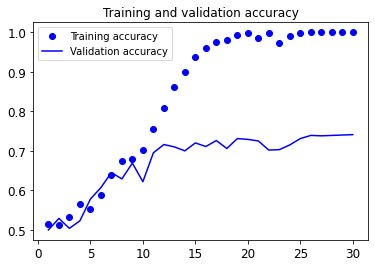

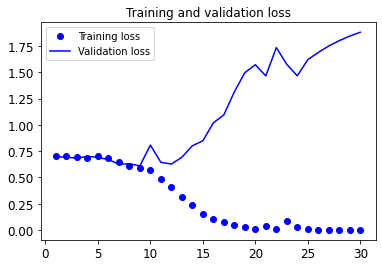

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

These plots **are characteristic of overfitting**. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy peaks at 74%. The validation loss reaches its minimum after only ten epochs and then stalls, whereas the training loss keeps decreasing linearly as training proceeds.

Let’s check the test accuracy. We’ll reload the model from its saved file to evaluate it as it was before it started overfitting.

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 55ms/step - loss: 0.6284 - accuracy: 0.6775
Test accuracy: 0.678


We get a test accuracy of about 68%. Because we have relatively few training samples (2,000), overfitting will be our number one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We’re now
going to work with a new one, specific to computer vision and used almost universally when processing images with deep learning models: data augmentation.

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model
would be exposed to every possible aspect of the data distribution at hand: you would never overfit. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples via a number of random transformations that yield believable-looking images. 

The goal is that, at training time, your model will never see the exact same picture twice. This helps expose the model
to more aspects of the data so it can generalize better.
In Keras, **this can be done by adding a number of data augmentation layers at the start of your model**. Let’s get started with an example: the following Sequential model
chains several random image transformations. In our model, we’d include it right before the Rescaling layer.

In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
    ]
)

Let’s quickly go over this code:
* `RandomFlip("horizontal")`—Applies horizontal flipping to a random 50% of the images that go through it
* `RandomRotation(0.1)`—Rotates the input images by a random value in the range `[–10%, +10%]` (these are fractions of a full circle—in degrees, the range would be `[–36 degrees, +36 degrees]`)
* `RandomZoom(0.2)`—Zooms in or out of the image by a random factor in the range `[-20%, +20%]`

https://www.tensorflow.org/guide/keras/preprocessing_layers#image_data_augmentation

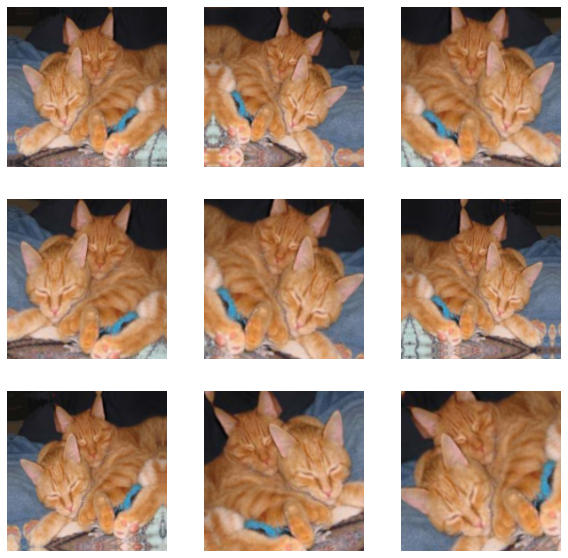

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1): #Sample 1 batch from the dataset
    for i in range(9):
      # During inference time, the output will be identical to input. 
      # Call the layer with training=True to flip the input.
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

If we train a new model using this data-augmentation configuration, the model will never see the same input twice. But the inputs it sees are still heavily intercorrelated because they come from a small number of original images—we can’t produce new information; we can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, we’ll also add a Dropout layer to our model right before the densely connected classifier.

One last thing you should know about random image augmentation layers: just like Dropout, they’re inactive during inference (when we call `predict()` or `evaluate()`).
During evaluation, our model will behave just the same as when it did not include data augmentation and dropout.

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.layers.Rescaling(1./255)(x)
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

Let’s train the model using data augmentation and dropout. **Because we expect overfitting to occur much later during training**, we will train for three times as many
epochs—one hundred.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 14s 160ms/step - loss: 0.6970 - accuracy: 0.5035 - val_loss: 0.6914 - val_accuracy: 0.5100
Epoch 2/100
63/63 [==============================] - 10s 149ms/step - loss: 0.6937 - accuracy: 0.4760 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 8s 120ms/step - loss: 0.6982 - accuracy: 0.5125 - val_loss: 0.6927 - val_accuracy: 0.5440
Epoch 4/100
63/63 [==============================] - 8s 120ms/step - loss: 0.6930 - accuracy: 0.5195 - val_loss: 0.6917 - val_accuracy: 0.5370
Epoch 5/100
63/63 [==============================] - 8s 121ms/step - loss: 0.6970 - accuracy: 0.5400 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 8s 121ms/step - loss: 0.6909 - accuracy: 0.5170 - val_loss: 0.6827 - val_accuracy: 0.5700
Epoch 7/100
63/63 [==============================] - 10s 152ms/step - loss: 0.6906 - accuracy: 0.5330 - val_loss: 0.6858 - val_accuracy: 0.5

Let’s plot the results again: Thanks to data augmentation and dropout, we start overfitting much later, around epochs 60–70 (compared to epoch 10 for the original model). The validation accuracy ends up consistently in the 80–85% range—a big improvement over our first try.

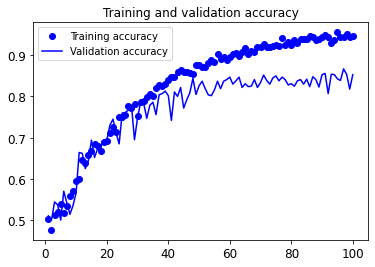

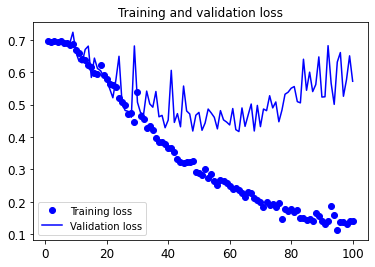

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Let’s check the test accuracy.

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 51ms/step - loss: 0.4555 - accuracy: 0.8310
Test accuracy: 0.831


We get a test accuracy of 83.1%. It’s starting to look good! 
By further tuning the model’s configuration (such as the number of filters per convolution layer, or the number of layers in the model), we might be able to get an
even better accuracy, likely up to 90%. But it would prove difficult to go any higher just by training our own convnet from scratch, because we have so little data to work
with. As a next step to improve our accuracy on this problem, we’ll have to use a pretrained model as we will see in Lecture 5.

# Implementing ResNet-34 using Keras

Most CNN architectures described so far are fairly straightforward to implement
(although generally you would load a pretrained network instead, as we will see in Lecture 5). To illustrate the process, let’s implement a ResNet-34 from scratch using Keras. First, let’s create a `ResidualUnit` layer:

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

As you can see, this code matches the resnet architecture pretty closely. In the constructor, we create all the layers we will need: the main layers are the ones on the right side of the diagram, and the skip layers are the ones on the left (only needed if the stride is greater than 1). Then in the `call()` method, we simply make the inputs go through the main layers, and the skip layers (if any), then we add both outputs and we apply the activation function.

<p align="center">
<img src="https://drive.google.com/uc?id=16SqAw_6OUiexu6l5uQRl9sI6joT8yqYC" alt="drawing" width="600"/>
</p>

Next, we can build the ResNet-34 simply using a Sequential model, since it is really just a long sequence of layers (we can treat each residual unit as a single layer now that we have the ResidualUnit class):

<p align="center">
<img src="https://drive.google.com/uc?id=1aEdiFekyJ7W5SZ9YiQf9_MAPsFtKGHnr" alt="drawing" width="600"/>
</p>


In [ ]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3])) # the size of images in imagenet
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

The only slightly tricky part in this code is the loop that adds the `ResidualUnit` layers to the model: as in the original architecture, the first 3 RUs have 64 filters, then the next 4 RUs have 128 filters, and so on. We then set the strides to 1 when the number of filters is the same as in the previous RU, or else we set it to 2. Then we add the `ResidualUnit`, and finally we update `prev_filters`.

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                      

It is quite amazing that in less than 40 lines of code, we can build the model that won the ILSVRC 2015 challenge! It demonstrates both the elegance of the ResNet model, and the expressiveness of the Keras API